In [15]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D, DepthwiseConv2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd
import random
import import_ipynb
import Sample_making
from models.cnn import CNN_model

In [2]:
df_target = pd.read_csv('../../Target_words_dataframe')
df_unknown = pd.read_csv('../../Unknown_words_dataframe')
df = pd.read_csv('../../full_df')

In [3]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
df

,word,path
0,yes,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
1,yes,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
2,yes,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
3,yes,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
4,yes,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
...,...,...
64716,unknown,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
64717,unknown,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
64718,unknown,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
64719,unknown,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...


In [46]:
filename = 'Data_spotter_mfcc_40'
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [6]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [7]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [8]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=42)

In [51]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58248, 40, 61)
Y_train size = (58248,)
X_test size = (6473, 40, 61)
Y_test size = (6473,)


In [52]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [53]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [54]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [55]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (58248, 40, 61, 1)
X_test size = (6473, 40, 61, 1)


In [56]:
def DS_CNN_model(input_shape, nclass):
    
    input_ = Input(input_shape)
    
    X = Convolution2D(300, (3, 3), activation="relu", dilation_rate=(2, 1), strides=(1, 1), padding="valid")(input_)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), dilation_rate=(1,1), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(300, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), dilation_rate=(2,2), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(300, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = DepthwiseConv2D(kernel_size=(10,3), strides=(1,1), dilation_rate=(1,1), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(300, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = DepthwiseConv2D(kernel_size=(5,3), strides=(1,1), dilation_rate=(2, 2), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(300, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = DepthwiseConv2D(kernel_size=(10,3), strides=(1,1), dilation_rate=(1,1), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(300, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    
    X = AveragePooling2D(pool_size=(X.shape[1], X.shape[2]))(X)
    
    X = Flatten()(X)
    X = Dropout(rate=0.2)(X)
    output_ = Dense(nclass, activation='softmax')(X)
    
    ret_model = Model(inputs = input_, outputs=output_)
    
    return ret_model

In [57]:
model = DS_CNN_model((40, 61, 1), len(lb.classes_))

In [58]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 40, 61, 1)]       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 36, 59, 300)       3000      
_________________________________________________________________
batch_normalization_152 (Bat (None, 36, 59, 300)       900       
_________________________________________________________________
activation_146 (Activation)  (None, 36, 59, 300)       0         
_________________________________________________________________
depthwise_conv2d_76 (Depthwi (None, 34, 57, 300)       3000      
_________________________________________________________________
batch_normalization_153 (Bat (None, 34, 57, 300)       900       
_________________________________________________________________
activation_147 (Activation)  (None, 34, 57, 300)       0   

In [60]:
# Обучалось на mfcc (40, 61) лежит в Data_spotter_mfcc

opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ["accuracy"])

model_history = model.fit(x = X_train, y = Y_train, epochs = 3, batch_size = 16, validation_data=(X_test, Y_test))

Epoch 1/3
3641/3641 [==============================] - 7739s 2s/step - loss: 0.1336 - accuracy: 0.7378 - val_loss: 0.0517 - val_accuracy: 0.9030
Epoch 2/3
3641/3641 [==============================] - 7710s 2s/step - loss: 0.0506 - accuracy: 0.9078 - val_loss: 0.0441 - val_accuracy: 0.9209
Epoch 3/3
3641/3641 [==============================] - 7760s 2s/step - loss: 0.0399 - accuracy: 0.9269 - val_loss: 0.0368 - val_accuracy: 0.9300


In [61]:
save_model(model, "DS_CNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DS_CNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DS_CNN 


In [62]:
model_history_1 = model.fit(x = X_train, y = Y_train, epochs=1, batch_size=16, validation_data=(X_test, Y_test))

3641/3641 [==============================] - 7799s 2s/step - loss: 0.0333 - accuracy: 0.9399 - val_loss: 0.0334 - val_accuracy: 0.9388


In [63]:
save_model(model, "DS_CNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DS_CNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\DS_CNN 


In [65]:
model_history.history['accuracy'] += model_history_1.history['accuracy']
model_history.history['val_accuracy'] += model_history_1.history['val_accuracy']

In [67]:
save_model_history(model_history.history, "DS_CNN")

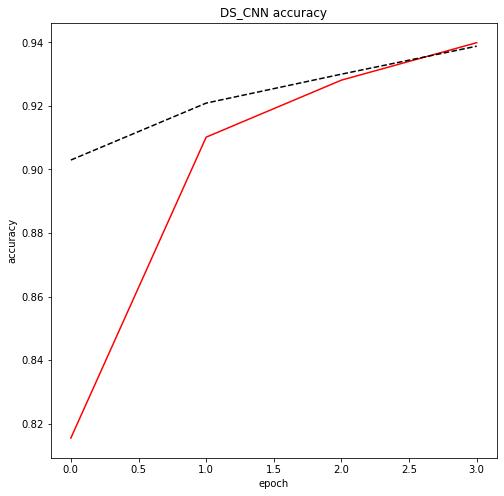

In [69]:
plt.figure(figsize=(8,8))
plt.plot(model_history.history['accuracy'], 
         color="red")
plt.plot(model_history.history['val_accuracy'], 
         color="black", 
         linestyle="dashed")
plt.title('DS_CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("DS_CNN")
plt.show()

In [ ]:
print(report(model, X_test, Y_test, lb.classes_))